In [2]:
#imports to work with...
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

from cl_framework.continual_learning.metrics.metric_evaluator_incdec import MetricEvaluatorIncDec
from cl_framework.utilities.matrix_logger import IncDecLogger
from torchmetrics import Recall
import itertools

In [2]:
subcategories_names = ['eating burger','eating cake','eating carrots','eating chips','eating doughnuts',
                       'eating hotdog','eating ice cream','eating spaghetti','eating watermelon','sucking lolly',
                       'tasting beer','tasting food','tasting wine','sipping cup','texting','talking on cell phone',
                       'looking at phone','smoking','smoking hookah','smoking pipe','sleeping','yawning','headbanging',
                       'headbutting','shaking head','scrubbing face','putting in contact lenses','putting on eyeliner',
                       'putting on foundation','putting on lipstick','putting on mascara','brushing hair','brushing teeth',
                       'braiding hair','combing hair','dyeing eyebrows','dyeing hair']
all_behaviors_dict = {
    'food': [
        'eating burger', 'eating cake', 'eating carrots', 'eating chips', 'eating doughnuts',
        'eating hotdog', 'eating ice cream', 'eating spaghetti', 'eating watermelon',
        'sucking lolly', 'tasting beer', 'tasting food', 'tasting wine', 'sipping cup'
    ],
    'phone': [
        'texting', 'talking on cell phone', 'looking at phone'
    ],
    'smoking': [
        'smoking', 'smoking hookah', 'smoking pipe'
    ],
    'fatigue': [
        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head'
    ],
    'selfcare': [
        'scrubbing face', 'putting in contact lenses', 'putting on eyeliner', 'putting on foundation',
        'putting on lipstick', 'putting on mascara', 'brushing hair', 'brushing teeth', 'braiding hair',
        'combing hair', 'dyeing eyebrows', 'dyeing hair'
    ]
}

In [3]:
# ap of subcategories
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'

path_to_baseline = '../runs_trainings/no_freeze/multilabel/weighted/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/no_freeze/decremental_multilabel/weighted/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/no_freeze/incremental_decremental_multilabel/weighted/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/no_freeze/joint_incremental_multilabel/weighted/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [4]:
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
no_freeze_path = os.path.join(ouput_ap_path,'no_freeze')
if not os.path.exists(no_freeze_path):
    os.mkdir(no_freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(no_freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [5]:
# recall of subcategories
mean_path = 'mean_over_tasks/forg_recall_per_subcategory.out'
std_path = 'std_over_tasks/forg_recall_per_subcategory.out'

path_to_baseline = '../runs_trainings/no_freeze/multilabel/weighted/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/no_freeze/decremental_multilabel/weighted/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/no_freeze/incremental_decremental_multilabel/weighted/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/no_freeze/joint_incremental_multilabel/weighted/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [6]:
# recall
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'recall')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
no_freeze_path = os.path.join(ouput_ap_path,'no_freeze')
if not os.path.exists(no_freeze_path):
    os.mkdir(no_freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Recall')
    ax.set_title('Subcategories Forgetting Recall - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(no_freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [7]:
# precision of subcategories
mean_path = 'mean_over_tasks/forg_precision_per_subcategory.out'
std_path = 'std_over_tasks/forg_precision_per_subcategory.out'

path_to_baseline = '../runs_trainings/no_freeze/multilabel/weighted/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/no_freeze/decremental_multilabel/weighted/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/no_freeze/incremental_decremental_multilabel/weighted/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/no_freeze/joint_incremental_multilabel/weighted/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [8]:
# precision
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'precision')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
no_freeze_path = os.path.join(ouput_ap_path,'no_freeze')
if not os.path.exists(no_freeze_path):
    os.mkdir(no_freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Precision')
    ax.set_title('Subcategories Forgetting Precision - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(no_freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [9]:
# accuracy of subcategories
mean_path = 'mean_over_tasks/forg_accuracy_per_subcategory.out'
std_path = 'std_over_tasks/forg_accuracy_per_subcategory.out'

path_to_baseline = '../runs_trainings/no_freeze/multilabel/weighted/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/no_freeze/decremental_multilabel/weighted/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/no_freeze/incremental_decremental_multilabel/weighted/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/no_freeze/joint_incremental_multilabel/weighted/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [10]:
# precision
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'accuracy')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
no_freeze_path = os.path.join(ouput_ap_path,'no_freeze')
if not os.path.exists(no_freeze_path):
    os.mkdir(no_freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Accuracy')
    ax.set_title('Subcategories Accuracy Precision - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(no_freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

FROM HERE ONLY FROZEN MODELS

In [3]:
# ap of subcategories
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'

path_to_baseline = '../runs_trainings/freeze_backbone/baseline_multilabel/weighted/new/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/freeze_backbone/decremental_multilabel/weighted/new/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/freeze_backbone/incremental_decremental_multilabel/weighted/new/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/freeze_backbone/joint_incremental_multilabel/weighted/new/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [4]:
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
freeze_path = os.path.join(ouput_ap_path,'freeze')
if not os.path.exists(freeze_path):
    os.mkdir(freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [5]:
# recall of subcategories
mean_path = 'mean_over_tasks/forg_recall_per_subcategory.out'
std_path = 'std_over_tasks/forg_recall_per_subcategory.out'

path_to_baseline = '../runs_trainings/freeze_backbone/baseline_multilabel/weighted/new/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/freeze_backbone/decremental_multilabel/weighted/new/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/freeze_backbone/incremental_decremental_multilabel/weighted/new/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/freeze_backbone/joint_incremental_multilabel/weighted/new/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [6]:
# recall
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'recall')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
freeze_path = os.path.join(ouput_ap_path,'freeze')
if not os.path.exists(freeze_path):
    os.mkdir(freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Recall')
    ax.set_title('Subcategories Forgetting Recall - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [7]:
# precision of subcategories
mean_path = 'mean_over_tasks/forg_precision_per_subcategory.out'
std_path = 'std_over_tasks/forg_precision_per_subcategory.out'

path_to_baseline = '../runs_trainings/freeze_backbone/baseline_multilabel/weighted/new/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/freeze_backbone/decremental_multilabel/weighted/new/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/freeze_backbone/incremental_decremental_multilabel/weighted/new/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/freeze_backbone/joint_incremental_multilabel/weighted/new/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [8]:
# precision
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'precision')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
freeze_path = os.path.join(ouput_ap_path,'freeze')
if not os.path.exists(freeze_path):
    os.mkdir(freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Precision')
    ax.set_title('Subcategories Forgetting Precision - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [9]:
# accuracy of subcategories
mean_path = 'mean_over_tasks/forg_accuracy_per_subcategory.out'
std_path = 'std_over_tasks/forg_accuracy_per_subcategory.out'

path_to_baseline = '../runs_trainings/freeze_backbone/baseline_multilabel/weighted/new/statistics/'
baseline_data = np.loadtxt(os.path.join(path_to_baseline,mean_path),delimiter=',')
baseline_std_data = np.loadtxt(os.path.join(path_to_baseline,std_path),delimiter=',')

path_to_decremental = '../runs_trainings/freeze_backbone/decremental_multilabel/weighted/new/statistics/'
decremental_data = np.loadtxt(os.path.join(path_to_decremental,mean_path),delimiter=',')
decremental_std_data = np.loadtxt(os.path.join(path_to_decremental,std_path),delimiter=',')

path_to_incdec = '../runs_trainings/freeze_backbone/incremental_decremental_multilabel/weighted/new/statistics/'
incdec_data = np.loadtxt(os.path.join(path_to_incdec,mean_path),delimiter=',')
incdec_std_data = np.loadtxt(os.path.join(path_to_incdec,std_path),delimiter=',')

path_to_joint = '../runs_trainings/freeze_backbone/joint_incremental_multilabel/weighted/new/statistics/'
joint_data = np.loadtxt(os.path.join(path_to_joint,mean_path),delimiter=',')
joint_std_data = np.loadtxt(os.path.join(path_to_joint,std_path),delimiter=',')

In [10]:
# precision
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_ap_path = os.path.join(output_path,'accuracy')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
freeze_path = os.path.join(ouput_ap_path,'freeze')
if not os.path.exists(freeze_path):
    os.mkdir(freeze_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    baseline_list = []
    decremental_list = []
    incdec_list = []
    joint_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_list.append(baseline_data[pos_subcat_in_data])
        decremental_list.append(decremental_data[pos_subcat_in_data])
        incdec_list.append(incdec_data[pos_subcat_in_data])
        joint_list.append(joint_data[pos_subcat_in_data])
        

    baseline_std_list = []
    decremental_std_list = []
    incdec_std_list = []
    joint_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        baseline_std_list.append(baseline_std_data[pos_subcat_in_data])
        decremental_std_list.append(decremental_std_data[pos_subcat_in_data])
        incdec_std_list.append(incdec_std_data[pos_subcat_in_data])
        joint_std_list.append(joint_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'Baseline': [baseline_list,baseline_std_list],
        'Decremental': [decremental_list,decremental_std_list],
        'Incdec': [incdec_list,incdec_std_list],
        'Joint': [joint_list,joint_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat Accuracy')
    ax.set_title('Subcategories Forgetting Accuracy - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(freeze_path + '/class_' + class_name + '.png')
    plt.close(fig)

COMPARISONS BETWEEN DIFFERENT METHODS

In [27]:
# Comparison between best results
# ap of subcategories on incdec
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/lwf/incremental_decremental/lambda_1/temp_1/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/no_freeze/incremental_decremental_multilabel/weighted/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/fd/incremental_decremental/lambda_01/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/freeze_backbone/incremental_decremental_multilabel/weighted/new/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')


In [28]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_comparison_path = os.path.join(output_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'incdec')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [29]:
# Comparison between best results
# ap of subcategories for decremental
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/lwf/decremental/lambda_1/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/no_freeze/decremental_multilabel/weighted/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/fd/decremental/lambda_01/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/freeze_backbone/decremental_multilabel/weighted/new/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')


In [30]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_comparison_path = os.path.join(output_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'decremental')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [31]:
# Comparison between best results
# ap of subcategories for joint_incremental
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/lwf/joint_incremental/lambda_1/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/no_freeze/joint_incremental_multilabel/weighted/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/fd/joint_incremental/lambda_01/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/freeze_backbone/joint_incremental_multilabel/weighted/new/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')

In [32]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_comparison_path = os.path.join(output_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'joint_incremental')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [33]:
# Comparison between best results
# ap of subcategories for baseline
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/lwf/baseline/lambda_1/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/no_freeze/multilabel/weighted/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/fd/baseline/lambda_01/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/freeze_backbone/baseline_multilabel/weighted/new/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')

In [34]:
# ap baseline
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
ouput_comparison_path = os.path.join(output_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'baseline')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

COMPARISONS BETWEEN DIFFERENT METHODS - Pretrained backbone

In [3]:
# Comparison between best results
# ap of subcategories on incdec
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/from_checkpoint_sgd/lwf/incremental_decremental/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_ewc = '../runs_trainings/from_checkpoint_sgd/ewc/lamb_500/incremental_decremental/statistics/'
ewc_data = np.loadtxt(os.path.join(path_to_ewc,mean_path),delimiter=',')
ewc_std_data = np.loadtxt(os.path.join(path_to_ewc,std_path),delimiter=',')

path_to_fd = '../runs_trainings/from_checkpoint_sgd/fd/incremental_decremental/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/from_checkpoint_sgd/freeze/incremental_decremental/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')


In [5]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
pre_trained_path = os.path.join(output_path,'pre_trained')
if not os.path.exists(pre_trained_path):
    os.mkdir(pre_trained_path)
ouput_comparison_path = os.path.join(pre_trained_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'incdec')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    ewc_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        ewc_list.append(ewc_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    ewc_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        ewc_std_list.append(ewc_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        'EWC': [ewc_list,ewc_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('{}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=45)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [37]:
# Comparison between best results
# ap of subcategories for decremental
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/from_checkpoint_sgd/lwf/decremental/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/from_checkpoint_sgd/no_freeze/decremental/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/from_checkpoint_sgd/fd/decremental/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/from_checkpoint_sgd/freeze/decremental/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')


In [38]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
pre_trained_path = os.path.join(output_path,'pre_trained')
if not os.path.exists(pre_trained_path):
    os.mkdir(pre_trained_path)
ouput_comparison_path = os.path.join(pre_trained_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'decremental')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [39]:
# Comparison between best results
# ap of subcategories for joint_incremental
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/from_checkpoint_sgd/lwf/joint_incremental/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/from_checkpoint_sgd/no_freeze/joint_incremental/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/from_checkpoint_sgd/fd/joint_incremental/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/from_checkpoint_sgd/freeze/joint_incremental/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')

In [40]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
pre_trained_path = os.path.join(output_path,'pre_trained')
if not os.path.exists(pre_trained_path):
    os.mkdir(pre_trained_path)
ouput_comparison_path = os.path.join(pre_trained_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'joint_incremental')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

In [41]:
# Comparison between best results
# ap of subcategories for baseline
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/from_checkpoint_sgd/lwf/data_substitution/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/from_checkpoint_sgd/no_freeze/data_substitution/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_fd = '../runs_trainings/from_checkpoint_sgd/fd/data_substitution/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/from_checkpoint_sgd/freeze/data_substitution/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')

In [42]:
# ap baseline
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
pre_trained_path = os.path.join(output_path,'pre_trained')
if not os.path.exists(pre_trained_path):
    os.mkdir(pre_trained_path)
ouput_comparison_path = os.path.join(pre_trained_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'baseline')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)

for class_name in all_behaviors_dict:
    subcat_names = all_behaviors_dict[class_name]

    nofreeze_list = []
    freeze_list = []
    lwf_list = []
    fd_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_list.append(nofreeze_data[pos_subcat_in_data])
        freeze_list.append(freeze_data[pos_subcat_in_data])
        lwf_list.append(lwf_data[pos_subcat_in_data])
        fd_list.append(fd_data[pos_subcat_in_data])
        

    nofreeze_std_list = []
    freeze_std_list = []
    lwf_std_list = []
    fd_std_list = []
    for idx_subcat in range(len(subcat_names)):
        pos_subcat_in_data = subcategories_names.index(subcat_names[idx_subcat])
        nofreeze_std_list.append(nofreeze_std_data[pos_subcat_in_data])
        freeze_std_list.append(freeze_std_data[pos_subcat_in_data])
        lwf_std_list.append(lwf_std_data[pos_subcat_in_data])
        fd_std_list.append(fd_std_data[pos_subcat_in_data])
        

    subcat_means = {
        'FineTune': [nofreeze_list,nofreeze_std_list],
        'FeatExtr': [freeze_list,freeze_std_list],
        'LWF': [lwf_list,lwf_std_list],
        'FD': [fd_list,fd_std_list],
        }

    x = np.arange(len(subcat_names))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurements in subcat_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurements[0], width, label=attribute)
        #ax.errorbar(x+offset, measurements[0], measurements[1], fmt='.', color='Black', elinewidth=1,capthick=5,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Forgetting on subcat AP')
    ax.set_title('Subcategories Forgetting AP - {}'.format(class_name))
    ax.set_xticks(x + width, subcat_names)
    ax.legend(loc='upper left', ncols=4)
    #ax.set_ylim(-5, 15)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(linewidth=1, color='black')
    fig.savefig(incdec_path + '/class_' + class_name + '.png')
    plt.close(fig)

TWO ...

In [12]:
subcategories_names = ['eating burger','eating cake','eating carrots','eating chips','eating doughnuts',
                       'eating hotdog','eating ice cream','eating spaghetti','eating watermelon','sucking lolly',
                       'tasting beer','tasting food','tasting wine','sipping cup','texting','talking on cell phone',
                       'looking at phone','smoking','smoking hookah','smoking pipe','sleeping','yawning','headbanging',
                       'headbutting','shaking head','scrubbing face','putting in contact lenses','putting on eyeliner',
                       'putting on foundation','putting on lipstick','putting on mascara','brushing hair','brushing teeth',
                       'braiding hair','combing hair','dyeing eyebrows','dyeing hair']
all_behaviors_dict = {
    'food': [
        'eating burger', 'eating cake', 'eating carrots', 'eating chips', 'eating doughnuts',
        'eating hotdog', 'eating ice cream', 'eating spaghetti', 'eating watermelon',
        'sucking lolly', 'tasting beer', 'tasting food', 'tasting wine', 'sipping cup'
    ],
    'phone': [
        'texting', 'talking on cell phone', 'looking at phone'
    ],
    'smoking': [
        'smoking', 'smoking hookah', 'smoking pipe'
    ],
    'fatigue': [
        'sleeping', 'yawning', 'headbanging', 'headbutting', 'shaking head'
    ],
    'selfcare': [
        'scrubbing face', 'putting in contact lenses', 'putting on eyeliner', 'putting on foundation',
        'putting on lipstick', 'putting on mascara', 'brushing hair', 'brushing teeth', 'braiding hair',
        'combing hair', 'dyeing eyebrows', 'dyeing hair'
    ]
}

In [13]:
# Comparison between best results
# ap of subcategories on incdec
mean_path = 'mean_over_tasks/forg_ap_per_subcategory.out'
std_path = 'std_over_tasks/forg_ap_per_subcategory.out'


path_to_lwf = '../runs_trainings/from_checkpoint_sgd/lwf/incremental_decremental/statistics/'
lwf_data = np.loadtxt(os.path.join(path_to_lwf,mean_path),delimiter=',')
lwf_std_data = np.loadtxt(os.path.join(path_to_lwf,std_path),delimiter=',')

path_to_nofreeze = '../runs_trainings/from_checkpoint_sgd/no_freeze/incremental_decremental/4_4_lr/statistics/'
nofreeze_data = np.loadtxt(os.path.join(path_to_nofreeze,mean_path),delimiter=',')
nofreeze_std_data = np.loadtxt(os.path.join(path_to_nofreeze,std_path),delimiter=',')

path_to_ewc = '../runs_trainings/from_checkpoint_sgd/ewc/lamb_500/incremental_decremental/statistics/'
ewc_data = np.loadtxt(os.path.join(path_to_ewc,mean_path),delimiter=',')
ewc_std_data = np.loadtxt(os.path.join(path_to_ewc,std_path),delimiter=',')

path_to_fd = '../runs_trainings/from_checkpoint_sgd/fd/incremental_decremental/statistics/'
fd_data = np.loadtxt(os.path.join(path_to_fd,mean_path),delimiter=',')
fd_std_data = np.loadtxt(os.path.join(path_to_fd,std_path),delimiter=',')

path_to_freeze = '../runs_trainings/from_checkpoint_sgd/freeze/incremental_decremental/statistics/'
freeze_data = np.loadtxt(os.path.join(path_to_freeze,mean_path),delimiter=',')
freeze_std_data = np.loadtxt(os.path.join(path_to_freeze,std_path),delimiter=',')


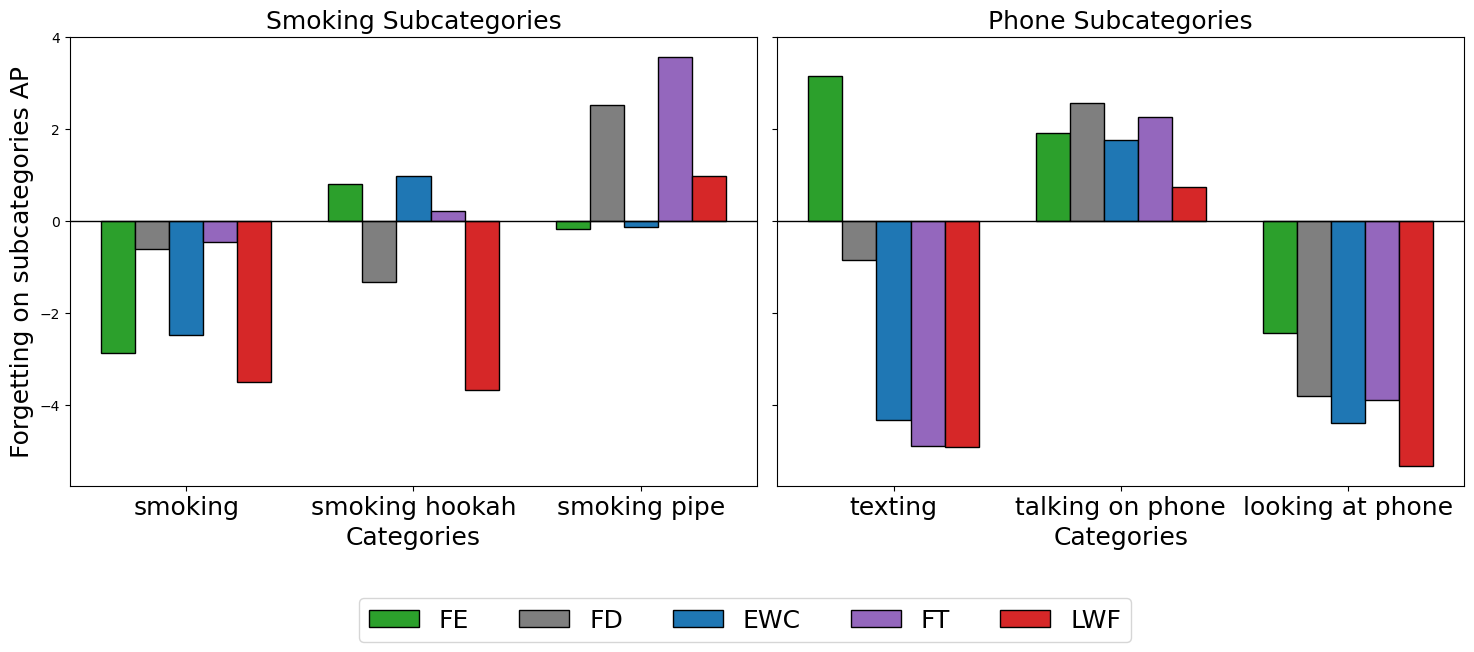

In [14]:
# ap incdec
output_path = '../statistics_to_save/subcategories_plots/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
pre_trained_path = os.path.join(output_path,'pre_trained')
if not os.path.exists(pre_trained_path):
    os.mkdir(pre_trained_path)
ouput_comparison_path = os.path.join(pre_trained_path,'comparison')
if not os.path.exists(ouput_comparison_path):
    os.mkdir(ouput_comparison_path)
ouput_ap_path = os.path.join(ouput_comparison_path,'ap')
if not os.path.exists(ouput_ap_path):
    os.mkdir(ouput_ap_path)
incdec_path = os.path.join(ouput_ap_path,'incdec')
if not os.path.exists(incdec_path):
    os.mkdir(incdec_path)


smoking_subcat_names = all_behaviors_dict['smoking']

smoking_subcat_values = {
    'Method': ['FE', 'FT', 'FD', 'EWC', 'LWF',
               'FE', 'FT', 'FD', 'EWC', 'LWF',
               'FE', 'FT', 'FD', 'EWC', 'LWF'],

    'Smoking': [],

    'Smoking Variance': [],
}

for idx_subcat in range(len(smoking_subcat_names)):
    pos_subcat_in_data = subcategories_names.index(smoking_subcat_names[idx_subcat])
    smoking_subcat_values['Smoking'].append(freeze_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking'].append(fd_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking'].append(ewc_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking'].append(nofreeze_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking'].append(lwf_data[pos_subcat_in_data])

    smoking_subcat_values['Smoking Variance'].append(freeze_std_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking Variance'].append(fd_std_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking Variance'].append(ewc_std_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking Variance'].append(nofreeze_std_data[pos_subcat_in_data])
    smoking_subcat_values['Smoking Variance'].append(lwf_std_data[pos_subcat_in_data])
    

x1 = np.arange(len(smoking_subcat_names))  # the label locations
width = 0.15  # the width of the bars


phone_subcat_names = all_behaviors_dict['phone']

phone_subcat_values = {
    'Method': ['FE', 'FT', 'FD', 'EWC', 'LWF',
               'FE', 'FT', 'FD', 'EWC', 'LWF',
               'FE', 'FT', 'FD', 'EWC', 'LWF',],


    'Phone': [],

    'Phone Variance': [],
}

for idx_subcat in range(len(phone_subcat_names)):
    pos_subcat_in_data = subcategories_names.index(phone_subcat_names[idx_subcat])
    phone_subcat_values['Phone'].append(freeze_data[pos_subcat_in_data])
    phone_subcat_values['Phone'].append(fd_data[pos_subcat_in_data])
    phone_subcat_values['Phone'].append(ewc_data[pos_subcat_in_data])
    phone_subcat_values['Phone'].append(nofreeze_data[pos_subcat_in_data])
    phone_subcat_values['Phone'].append(lwf_data[pos_subcat_in_data])

    phone_subcat_values['Phone Variance'].append(freeze_std_data[pos_subcat_in_data])
    phone_subcat_values['Phone Variance'].append(fd_std_data[pos_subcat_in_data])
    phone_subcat_values['Phone Variance'].append(ewc_std_data[pos_subcat_in_data])
    phone_subcat_values['Phone Variance'].append(nofreeze_std_data[pos_subcat_in_data])
    phone_subcat_values['Phone Variance'].append(lwf_std_data[pos_subcat_in_data])

x2 = np.arange(len(phone_subcat_names))  # the label locations



# Convert dictionaries to DataFrames
smoking_subcat_df = pd.DataFrame(smoking_subcat_values)
phone_subcat_df = pd.DataFrame(phone_subcat_values)

# Define positions for the bar plots
x1 = np.arange(len(all_behaviors_dict['smoking']))
x2 = np.arange(len(all_behaviors_dict['phone']))
width = 0.15

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Order the methods and define a list of colors
ordered_methods = ['FE', 'FD', 'EWC', 'FT', 'LWF']
position_map = {method: i for i, method in enumerate(ordered_methods)}
colors = ['tab:green', 'tab:grey', 'tab:blue', 'tab:purple', 'tab:red']

# Cycle through the colors if there are more lines than colors
color_cycle = itertools.cycle(colors)

# Plotting Smoking
for method in ordered_methods:
    color = next(color_cycle)
    sub_df = smoking_subcat_df[smoking_subcat_df['Method'] == method]
    pos = position_map[method]
    ax1.bar(x1 + pos * width, sub_df['Smoking'].values, width,
            label=f'{method}', capsize=5, color=color, edgecolor='black')

# Reset color cycle for the second plot
color_cycle = itertools.cycle(colors)

# Plotting Phone
for method in ordered_methods:
    color = next(color_cycle)
    sub_df = phone_subcat_df[phone_subcat_df['Method'] == method]
    pos = position_map[method]
    ax2.bar(x2 + pos * width, sub_df['Phone'].values, width,
            label=f'{method}', capsize=5, color=color, edgecolor='black')

# Set labels and titles
fontsize = 18
ax1.set_xlabel('Categories', fontsize=fontsize)
ax1.set_ylabel('Forgetting on subcategories AP', fontsize=fontsize)
ax1.set_title('Smoking Subcategories', fontsize=fontsize)
ax1.set_xticks(x1 + width * (len(ordered_methods) - 1) / 2)
ax1.set_xticklabels(all_behaviors_dict['smoking'], fontsize=fontsize)

# modify talking on cell phone
phone_x_label = all_behaviors_dict['phone']
ind = all_behaviors_dict['phone'].index('talking on cell phone')
all_behaviors_dict['phone'][ind] = 'talking on phone'


ax2.set_xlabel('Categories', fontsize=fontsize)
ax2.set_title('Phone Subcategories', fontsize=fontsize)
ax2.set_xticks(x2 + width * (len(ordered_methods) - 1) / 2)
ax2.set_xticklabels(all_behaviors_dict['phone'], fontsize=fontsize)

ax1.axhline(linewidth=1, color='black')
ax2.axhline(linewidth=1, color='black')

# Combine legends for both subplots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1, labels1, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1), fontsize=fontsize)

# Adjust layout and display plot
fig.tight_layout(rect=[0, 0.05, 1, 1])
#plt.ylim(20, 90)
plt.show()
fig.savefig(os.path.join(incdec_path, 'comparison.pdf'), bbox_inches='tight')